In [10]:
# -----------------------------------------
# FINAL PROJECT – STEPS 2 & 3 (with features)
# Feature engineering + ML models
# -----------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# -------------------------------------------------
# 1. Load simulation results (Step 1 outputs)
# -------------------------------------------------

root_dir = os.getcwd()

params_path = os.path.join(root_dir, "all_parameters.csv")
results_path = os.path.join(root_dir, "results.csv")

params = pd.read_csv(params_path)
results = pd.read_csv(results_path)

df = params.merge(results, on="case_id")
print("Merged dataframe shape:", df.shape)
df.head()


Merged dataframe shape: (1944, 9)


,case_id,Location,Wall_Rvalue,WWR,SHGC,Occupancy_Density,Lights_Density,Cooling_Setpoint,Total_Cooling_kwh
0,0,San Francisco,14.3,0.25,0.25,0.04,7.5,24,142.799147
1,1,San Francisco,14.3,0.25,0.25,0.04,7.5,26,18.650602
2,2,San Francisco,14.3,0.25,0.25,0.04,7.5,28,0.236016
3,3,San Francisco,14.3,0.25,0.25,0.04,9.0,24,170.415614
4,4,San Francisco,14.3,0.25,0.25,0.04,9.0,26,24.823386


In [11]:
# -------------------------------------------------
# 2. Climate indicator: Cooling Degree Days (CDD18C)
# -------------------------------------------------

def compute_cdd18c_from_epw(epw_path, base_temp_c=18.0):
    """
    Compute annual Cooling Degree Days (CDD) with base temperature (deg C)
    from an EPW file.

    EPW format: dry-bulb temperature is column 7 (0-based index 6).
    """
    # EPW has 8 header lines, data starts after that
    data = pd.read_csv(epw_path, header=None, skiprows=8)

    # Dry-bulb temperature column
    dry_bulb = data[6].astype(float)

    # Hourly CDD: max(T - base, 0)
    cdd_hourly = np.maximum(dry_bulb - base_temp_c, 0.0)

    # Annual CDD in degree-days (sum of hourly excess, then /24)
    cdd_annual = cdd_hourly.sum() / 24.0
    return cdd_annual


In [12]:
# Map of locations to EPW files (same as Notebook 1)
MAP_WEATHER = {
    "San Francisco": os.path.join(root_dir, r"weather_data\USA_CA_San.Francisco.Intl.AP.724940_TMY3.epw"),
    "Sacramento":    os.path.join(root_dir, r"weather_data\USA_CA_Sacramento.Exec.AP.724830_TMY3.epw"),
    "Chicago":       os.path.join(root_dir, r"weather_data\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw"),
    "New York":      os.path.join(root_dir, r"weather_data\USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw"),
}

print("Checking EPW files:")
for loc, p in MAP_WEATHER.items():
    print(f"  {loc}: {p}  ->  exists? {os.path.exists(p)}")

# Compute CDD18C for each city
cdd_map = {}
for loc, epw_path in MAP_WEATHER.items():
    cdd_map[loc] = compute_cdd18c_from_epw(epw_path)

cdd_map


Checking EPW files:
  San Francisco: C:\Users\jerry\Desktop\projects\Arch 298 Energy Plus\Final_Project\notebooks\weather_data\USA_CA_San.Francisco.Intl.AP.724940_TMY3.epw  ->  exists? True
  Sacramento: C:\Users\jerry\Desktop\projects\Arch 298 Energy Plus\Final_Project\notebooks\weather_data\USA_CA_Sacramento.Exec.AP.724830_TMY3.epw  ->  exists? True
  Chicago: C:\Users\jerry\Desktop\projects\Arch 298 Energy Plus\Final_Project\notebooks\weather_data\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw  ->  exists? True
  New York: C:\Users\jerry\Desktop\projects\Arch 298 Energy Plus\Final_Project\notebooks\weather_data\USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw  ->  exists? True


{'San Francisco': np.float64(131.96666666666667),
 'Sacramento': np.float64(811.5416666666666),
 'Chicago': np.float64(599.3125),
 'New York': np.float64(685.9625)}

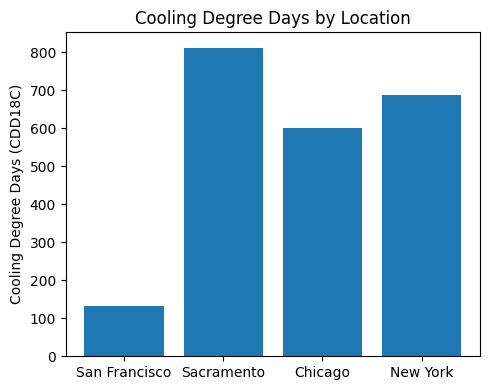

In [20]:
plt.figure(figsize=(5, 4))
plt.bar(cdd_map.keys(), cdd_map.values())
plt.ylabel("Cooling Degree Days (CDD18C)")
plt.title("Cooling Degree Days by Location")
plt.tight_layout()
plt.show()


In [13]:
# Add CDD18C to each row based on its Location
df["CDD18C"] = df["Location"].map(cdd_map)

# Derived feature: WWR × SHGC (solar gain intensity proxy)
df["WWR_SHGC"] = df["WWR"] * df["SHGC"]

df[["Location", "CDD18C", "WWR", "SHGC", "WWR_SHGC"]].head()


,Location,CDD18C,WWR,SHGC,WWR_SHGC
0,San Francisco,131.966667,0.25,0.25,0.0625
1,San Francisco,131.966667,0.25,0.25,0.0625
2,San Francisco,131.966667,0.25,0.25,0.0625
3,San Francisco,131.966667,0.25,0.25,0.0625
4,San Francisco,131.966667,0.25,0.25,0.0625


In [14]:
# ---------------------------------------------
# 3. Define features (X) and target (y)
# ---------------------------------------------

feature_cols = [
    # Design variables
    "Wall_Rvalue",
    "WWR",
    "SHGC",
    "Occupancy_Density",
    "Lights_Density",
    "Cooling_Setpoint",
    # Climate indicator
    "CDD18C",
    # Derived feature
    "WWR_SHGC",
]

X = df[feature_cols].copy()
y = df["Total_Cooling_kwh"]

print("Feature matrix shape:", X.shape)
X.head()


Feature matrix shape: (1944, 8)


,Wall_Rvalue,WWR,SHGC,Occupancy_Density,Lights_Density,Cooling_Setpoint,CDD18C,WWR_SHGC
0,14.3,0.25,0.25,0.04,7.5,24,131.966667,0.0625
1,14.3,0.25,0.25,0.04,7.5,26,131.966667,0.0625
2,14.3,0.25,0.25,0.04,7.5,28,131.966667,0.0625
3,14.3,0.25,0.25,0.04,9.0,24,131.966667,0.0625
4,14.3,0.25,0.25,0.04,9.0,26,131.966667,0.0625


In [15]:
# ---------------------------------------------
# 4. Train / test split (hold out Sacramento)
# ---------------------------------------------

train_mask = df["Location"] != "Sacramento"
test_mask  = df["Location"] == "Sacramento"

X_train = X[train_mask]
X_test  = X[test_mask]
y_train = y[train_mask]
y_test  = y[test_mask]

print("Train size:", X_train.shape[0], " Test size:", X_test.shape[0])


Train size: 1458  Test size: 486


In [16]:
# ---------------------------------------------
# 5. Train models and evaluate performance
# ---------------------------------------------

models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(
        random_state=0,
        max_depth=10
    ),
    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        random_state=0,
        max_depth=None,
        n_jobs=-1,
    ),
}

metrics = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    metrics.append({
        "model": name,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
    })

metrics_df = pd.DataFrame(metrics)
print("Model performance on Sacramento (test set):")
metrics_df


Model performance on Sacramento (test set):


,model,MSE,RMSE,MAE,R2
0,LinearRegression,120059.179424,346.495569,302.897062,0.819335
1,DecisionTree,53499.369720,231.299308,153.665703,0.919494
2,RandomForest,53308.966144,230.887345,151.576026,0.919781


Best model based on RMSE: RandomForest


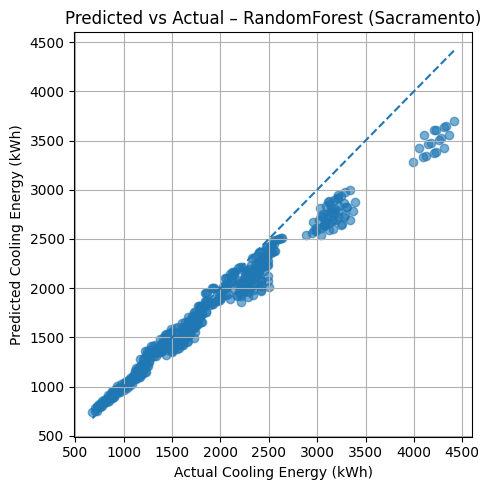

In [17]:
# ---------------------------------------------
# 6. Predicted vs Actual plot (best model)
# ---------------------------------------------

best_model_name = metrics_df.sort_values("RMSE").iloc[0]["model"]
best_model = models[best_model_name]
print("Best model based on RMSE:", best_model_name)

y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred_best, alpha=0.6)
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("Actual Cooling Energy (kWh)")
plt.ylabel("Predicted Cooling Energy (kWh)")
plt.title(f"Predicted vs Actual – {best_model_name} (Sacramento)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
# ---------------------------------------------
# 7. Feature importance (Random Forest)
# ---------------------------------------------

rf = models["RandomForest"]
importances = rf.feature_importances_
feat_names = X.columns

fi_df = pd.DataFrame({
    "feature": feat_names,
    "importance": importances,
}).sort_values("importance", ascending=False)

print("Random Forest feature importances:")
fi_df


Random Forest feature importances:


,feature,importance
6,CDD18C,0.560596
5,Cooling_Setpoint,0.240909
7,WWR_SHGC,0.188839
3,Occupancy_Density,0.005757
0,Wall_Rvalue,0.001542
4,Lights_Density,0.000888
1,WWR,0.000738
2,SHGC,0.000731


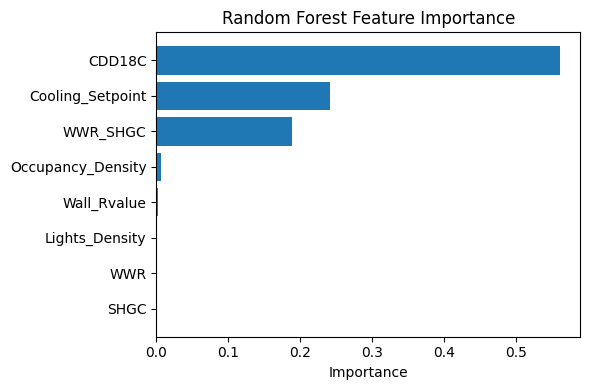

In [19]:
plt.figure(figsize=(6, 4))
plt.barh(fi_df["feature"], fi_df["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()
